In [8]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math as math
import pybinding as pb
from pybinding.repository import graphene
pb.pltutils.use_style()
from IPython.display import display, HTML

In [9]:
a = 3*graphene.a_cc # lattice length.
a_cc = graphene.a_cc # carbon-carbon bond length
t = graphene.t # hopping energy of graphene.
leng_z = (7)*math.sqrt(3)*a_cc #lengh of supercell that I wanna make
m = 0.001 
plt.rcParams.update({'font.size': 15})


#Topological -> 위상 기하적
#넓은것과 좁은것이 또 합쳐저서 하나의 unit cel이 됨.
#상태에 따라서 에너지나 property가 많이 달라짐.
# LAPACK -> exact diag . must in small system.


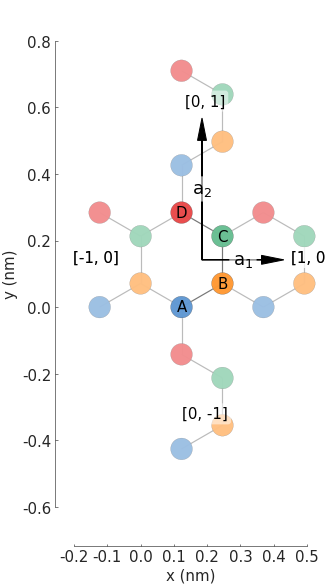

In [10]:
def zigzag_graphene() :
    
    lat = pb.Lattice(a1=[math.sqrt(3)*a_cc,0], a2 = [0,a]) #lattice vector
    
    lat.add_sublattices(
        ('A',[math.sqrt(3)/2*a_cc,0]),
        ('B',[math.sqrt(3)/2*a_cc+math.sqrt(3)/2*a_cc,1/2*a_cc]),
        ('C',[math.sqrt(3)/2*a_cc+math.sqrt(3)/2*a_cc,3/2*a_cc]),
        ('D',[math.sqrt(3)/2*a_cc,2*a_cc]),
        )
                        
    lat.add_hoppings(
        ([0,0], 'A', 'B', t),
        ([0,0], 'B', 'C', t),
        ([0,0], 'C', 'D', t),
        ([1,0],'B','A',t),
        ([-1,0],'D','C',t), 
        ([0,1],'D','A',t) 
    )
    
    return lat

plt.figure(figsize=(10,10))
zigzag = zigzag_graphene()
zigzag.plot()
plt.show()

How many supercell you want to make?
5


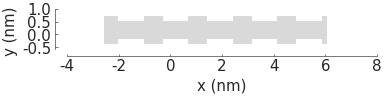

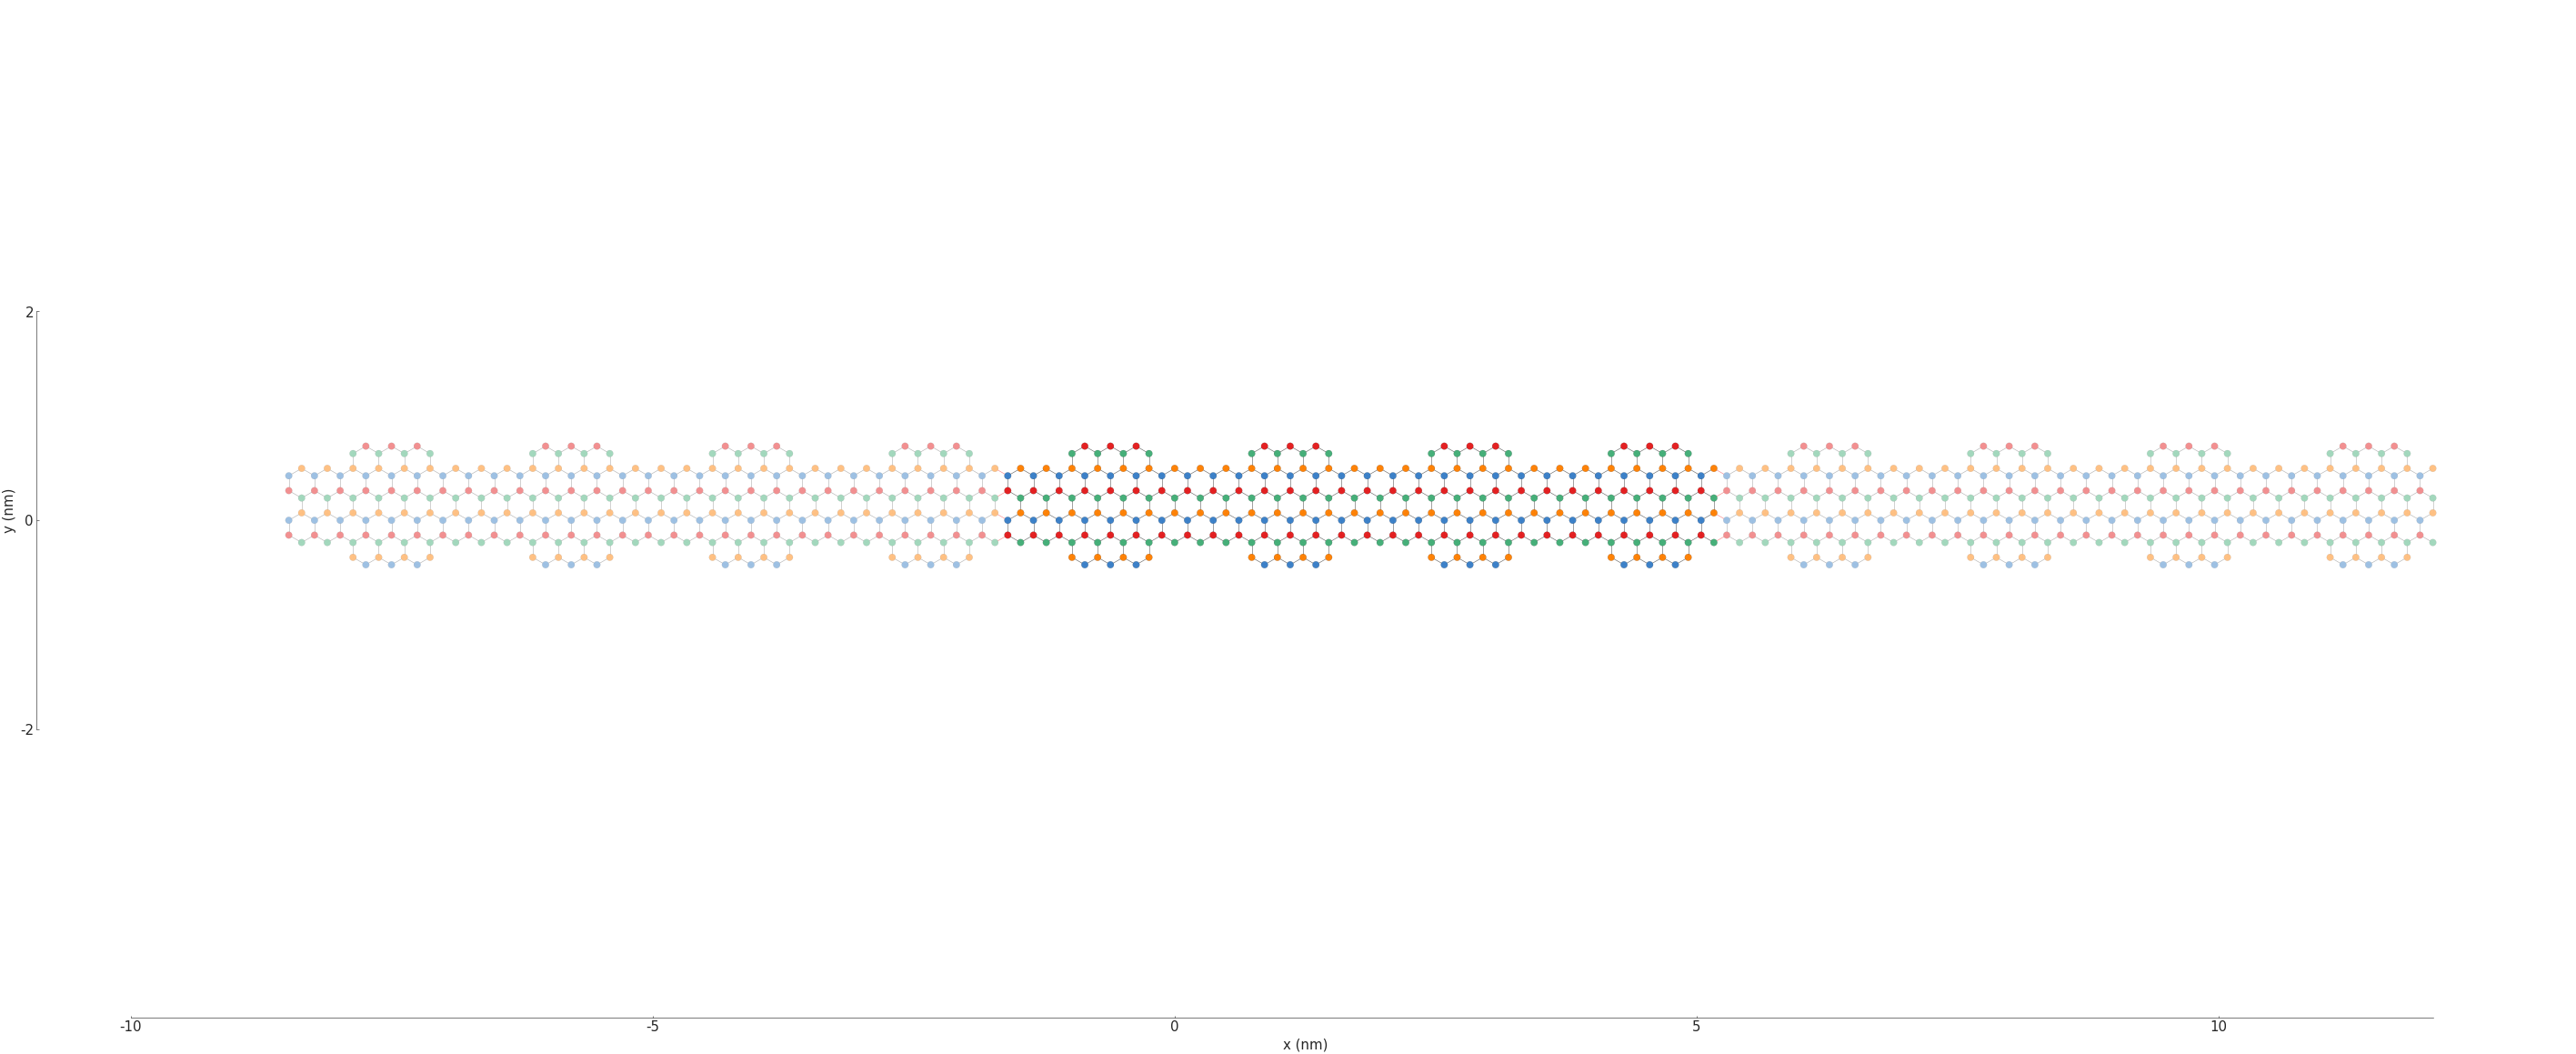

In [11]:
def shape(T) : # T is the period of the shape
    rect = pb.rectangle(x=leng_z+100*m, y=10/2*math.sqrt(3)*a_cc) 
    rect_exc= pb.rectangle(x=leng_z/2, y=2*a_cc) # rectangle that wil lbe excluded

   
    tr_rect = rect.with_offset([leng_z*(T-1),a_cc])
    tr_rect_down = rect_exc.with_offset([leng_z*(T-1)+3/2*a_cc, a_cc-4*a_cc]) #3/2*a_cc
    tr_rect_up = rect_exc.with_offset([leng_z*(T-1)+3/2*a_cc, a_cc+4*a_cc]) #3/2*a_cc
    shape_1 = tr_rect - tr_rect_down -tr_rect_up    

    return shape_1

supercell_A = shape(0)

print('How many supercell you want to make?')
inp = input() 

for i in range (0,int(inp)) :
    supercell_A += shape(i)
    
    
supercell_A.plot()
#arm_gra = pb.Model(lattice, shape())#,pb.translational_symmetry(a1=18*a_cc,a2=False))
#arm_gra.plot()
#arm_gra.shape.plot()

plt.figure(figsize=(50, 20.6))
zz_gra_A = pb.Model(zigzag, supercell_A, pb.translational_symmetry(a1=(int(inp)-1)*leng_z ,a2=False))
zz_gra_A.plot()
#arm_gra.shape.plot()

How many supercell you want to make?
5


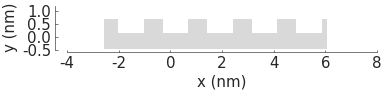

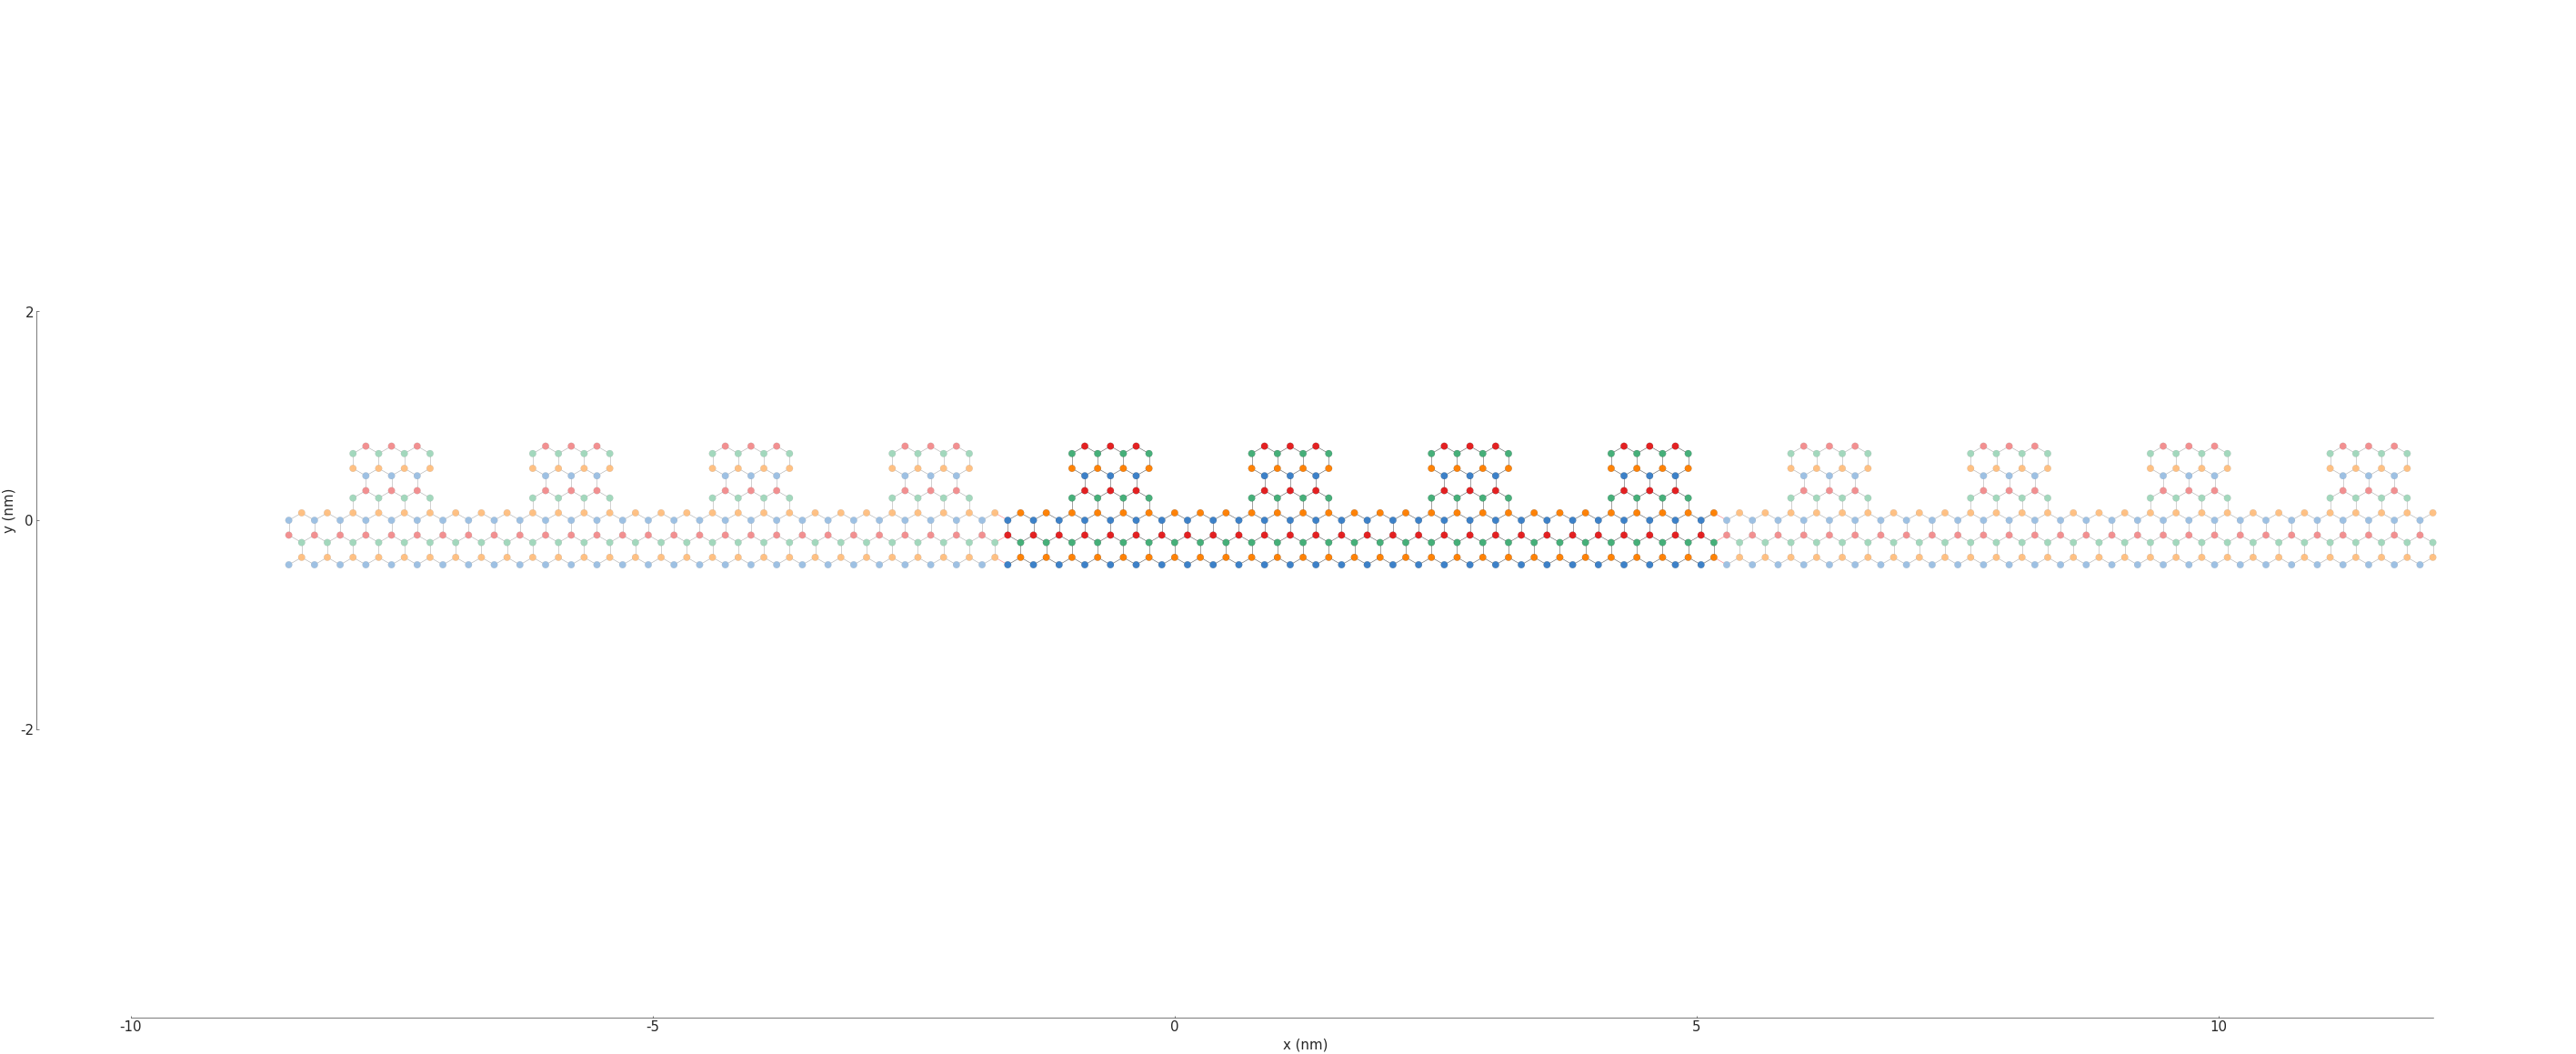

In [12]:
def shape(T) : # T is the period of the shape
    rect = pb.rectangle(x=leng_z+100*m, y=10/2*math.sqrt(3)*a_cc) 
    rect_exc= pb.rectangle(x=leng_z/2, y=7*a_cc) # rectangle that wil lbe excluded

   
    tr_rect = rect.with_offset([leng_z*(T-1),a_cc])
    tr_rect_down = rect_exc.with_offset([leng_z*(T-1)+3/2*a_cc, a_cc-4*a_cc]) #3/2*a_cc
    tr_rect_up = rect_exc.with_offset([leng_z*(T-1)+3/2*a_cc, a_cc+4*a_cc]) #3/2*a_cc
    shape_1 = tr_rect -tr_rect_up    # - tr_rect_down 

    return shape_1

supercell_A = shape(0)

print('How many supercell you want to make?')
inp = input() 

for i in range (0,int(inp)) :
    supercell_A += shape(i)
    
    
supercell_A.plot()
#arm_gra = pb.Model(lattice, shape())#,pb.translational_symmetry(a1=18*a_cc,a2=False))
#arm_gra.plot()
#arm_gra.shape.plot()

plt.figure(figsize=(50, 20.6))
zz_gra_B = pb.Model(zigzag, supercell_A, pb.translational_symmetry(a1=(int(inp)-1)*leng_z ,a2=False))
zz_gra_B.plot()
#arm_gra.shape.plot()

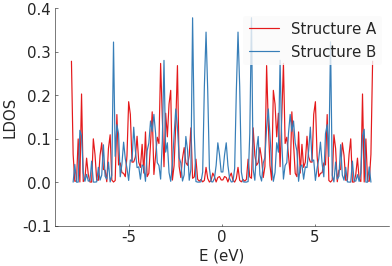

In [13]:
from pybinding.repository import graphene

kpmA = pb.kpm(zz_gra_A)
kpmB = pb.kpm(zz_gra_B)
ldosA = kpmA.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldosB = kpmB.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])

plt.plot(figsize=(30, 30))
ldosA.plot(label="Structure A")
ldosB.plot(label="Structure B")





pb.pltutils.legend()

In [14]:
def mass_termy(V1,w1,w2,w3):
#This function makes potential difference along y axes. And it changes suddenly
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy[y>=0] += V1
        energy[y<0] -= V1
        return energy
    
    return potential


def mass_termy_kink(V1,w1,w2,w3):
#This function makes potential difference along y axes. And it changes gradually
    @pb.onsite_energy_modifier
    def potential(energy, sub_id,x,y):
        yrange=w3*3*(w1+w2)*graphene.a_cc/2
        energy[y>=yrange] += V1
        energy[(y<yrange)&(y>=-yrange)] += V1/(yrange)*y[(y<yrange)&(y>=-yrange)]
        energy[y<-yrange] -= V1
        return energy

    return potential


def mass_term_siny(V1,w1,w2,w3):
#potential equals to siny
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy += V1*sin(2*pi*y/(3*(w1+w2)*graphene.a_cc))
        return energy
    
    return potential


In [19]:
def energy(str):
    #w4 is width of none potential changnig direction
    #e1 is magnitute of the potential
    plt.figure(figsize=(20,20))
    
    #normal
    plt.subplot(231)
    solver = pb.solver.lapack(str)
    eigenvalues = solver.eigenvalues

    a_cc = graphene.a_cc
    Gamma = [0, 0]
    K1 = [math.pi/leng_z/(int(inp)-1), 0]
    bands = solver.calc_bands(K1, Gamma)
    bands.plot(point_labels=['K', r'$\Gamma$'])
    plt.ylim(-2,2)

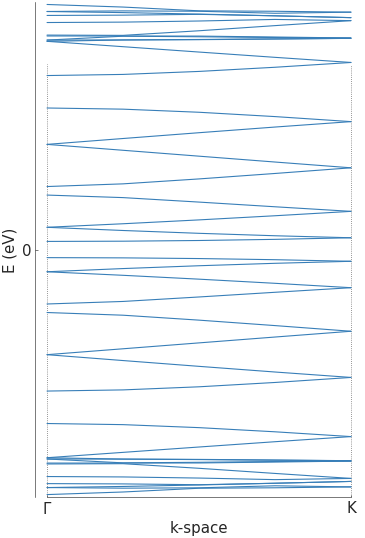

In [20]:
energy(zz_gra_A)